In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import imread, IMREAD_GRAYSCALE
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
import captum
from captum.attr import GuidedGradCam, GuidedBackprop
from captum.attr import LayerConductance, LayerGradCam
from sklearn.utils import compute_class_weight
from utils import *
from models.cnn import CNN
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Data Loading and Preprocessing

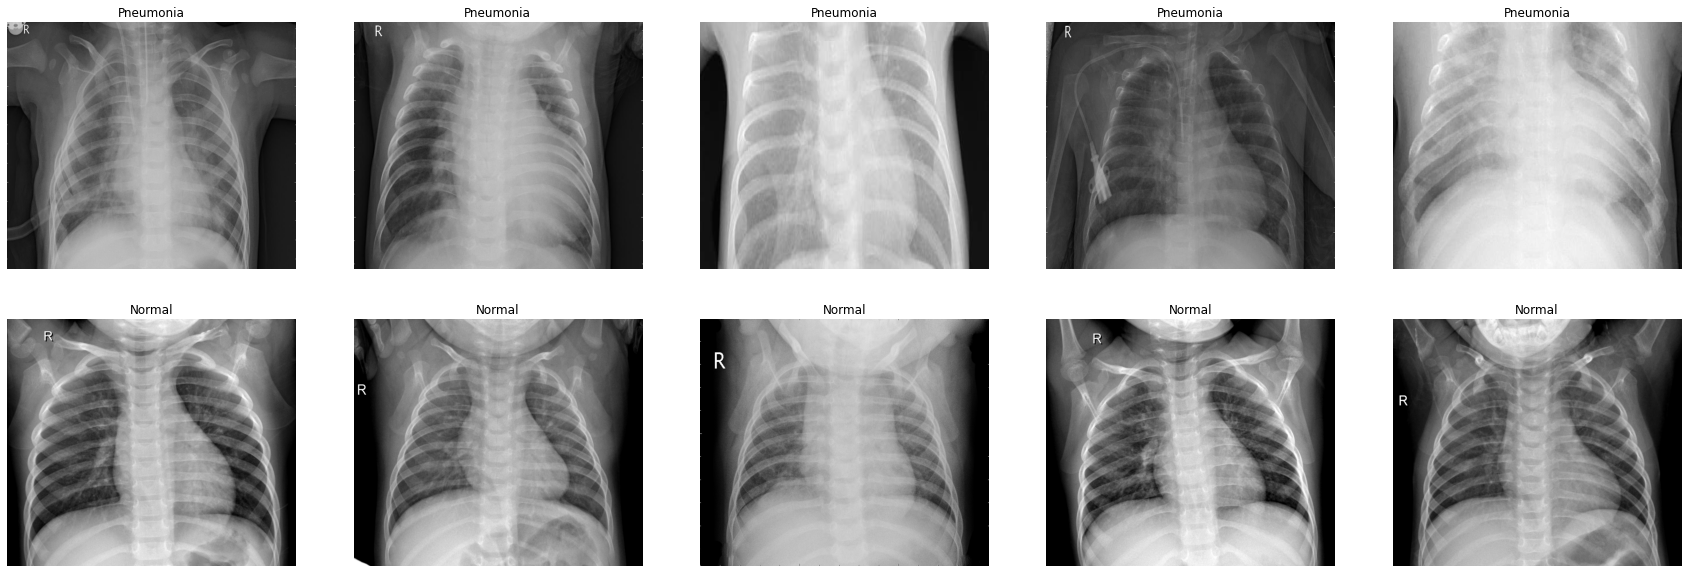

In [4]:
dataset = get_data()
pneumonia_samples = dataset[dataset['class']==1]['filename'].iloc[:5]
normal_samples = dataset[dataset['class']==0]['filename'].iloc[:5]

samples = pd.concat([pneumonia_samples, normal_samples]).to_list()

_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i], IMREAD_GRAYSCALE)
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

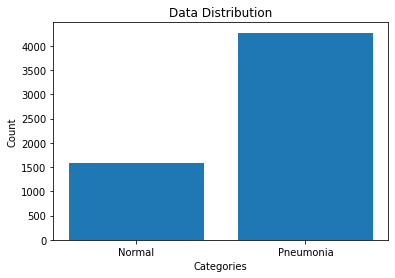

In [5]:
# Plot Image Distribution
categories = ['Normal', 'Pneumonia']
frequencies = list(dataset['class'].value_counts())[::-1]
plt.bar(categories, frequencies)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title('Data Distribution')
plt.show()

In [6]:
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.00175
REGULARIZATION = 1e-4
IMG_SIZE = (128, 128)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the {DEVICE.type}')

Using the cuda


In [7]:
data_transforms = transforms.Compose([
    ToTensor(),
    transforms.RandomAffine(degrees=0, shear=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [8]:
train_split = dataset.iloc[:round(len(dataset) * 0.8)]
val_split = dataset.iloc[round(len(dataset) * 0.8): round(len(dataset) * 0.9)]
test_split = dataset.iloc[round(len(dataset) * 0.9):]

train_dataloader = get_dataloader(train_split, BATCH_SIZE, img_size=IMG_SIZE, transform=data_transforms)
val_dataloader = get_dataloader(val_split, BATCH_SIZE, img_size=IMG_SIZE)
test_dataloader = get_dataloader(test_split, BATCH_SIZE, shuffle=False, img_size=IMG_SIZE)

# Initialize and Train the Model

In [10]:
model = CNN().to(DEVICE)
print(f"Model summary\n-------------------------------\n{model}")

Model summary
-------------------------------
CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=16384, out_features=512, bias=True)
    (14): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
history = {
    'losses': [],
    'val_losses': [],
    'accuracies':[],
    'val_accuracies':[],
    'precisions': [],
    'val_precisions': [],
    'recalls': [],
    'val_recalls': [],
    'specificities': [],
    'val_specificities': [],
}

In [12]:
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(
        train_dataloader,
        model,
        optimizer,
        DEVICE,
        history
    )
    evaluate(
        val_dataloader,
        model,
        DEVICE,
        history
    )
print("Done!")

Epoch 1
-------------------------------
loss: 0.697248  [    0/ 4685]
loss: 0.593166  [  320/ 4685]
loss: 0.754856  [  640/ 4685]
loss: 0.594734  [  960/ 4685]
loss: 0.645333  [ 1280/ 4685]
loss: 0.621902  [ 1600/ 4685]
loss: 0.696243  [ 1920/ 4685]
loss: 0.537207  [ 2240/ 4685]
loss: 0.555387  [ 2560/ 4685]
loss: 0.585263  [ 2880/ 4685]
loss: 0.456776  [ 3200/ 4685]
loss: 0.516666  [ 3520/ 4685]
loss: 0.508308  [ 3840/ 4685]
loss: 0.332196  [ 4160/ 4685]
loss: 0.343697  [ 4480/ 4685]
Test Metrics:
Loss: 0.346985, Accuracy: 80.5%, Precision: 82.6%, Recall: 96.8%, Specificity: 91.9%

Epoch 2
-------------------------------
loss: 0.320572  [    0/ 4685]
loss: 0.453795  [  320/ 4685]
loss: 0.242149  [  640/ 4685]
loss: 0.177448  [  960/ 4685]
loss: 0.426658  [ 1280/ 4685]
loss: 0.108888  [ 1600/ 4685]
loss: 0.212014  [ 1920/ 4685]
loss: 0.085551  [ 2240/ 4685]
loss: 0.118073  [ 2560/ 4685]
loss: 0.100180  [ 2880/ 4685]
loss: 0.237857  [ 3200/ 4685]
loss: 0.270342  [ 3520/ 4685]
loss: 0.36

In [13]:
print('Evaluating on Test Data\n-----------------------------')
y_pred, y_true = evaluate(
    test_dataloader,
    model,
    DEVICE,
    history,
    mode='test'
)

Evaluating on Test Data
-----------------------------
Test Metrics:
Loss: 0.115617, Accuracy: 94.9%, Precision: 97.7%, Recall: 96.3%, Specificity: 90.0%



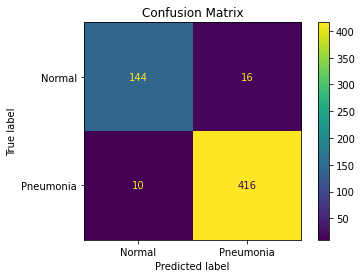

In [14]:
plot_confusion_matrix(y_pred, y_true)

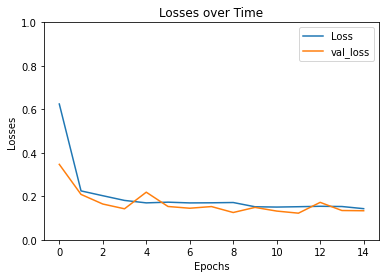

In [15]:
plt.plot(history['losses'], label='Loss')
plt.plot(history['val_losses'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.ylim(0, 1)
plt.title("Losses over Time")
plt.legend()
plt.show()

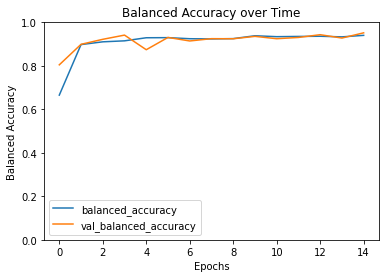

In [16]:
plt.plot(history['accuracies'], label='balanced_accuracy')
plt.plot(history['val_accuracies'], label = 'val_balanced_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.ylim(0, 1)
plt.title("Balanced Accuracy over Time")
plt.legend()
plt.show()

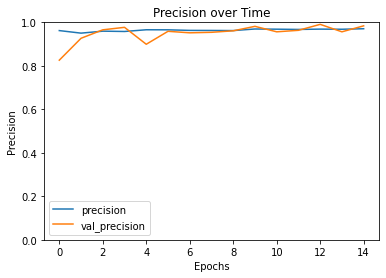

In [17]:
plt.plot(history['precisions'], label='precision')
plt.plot(history['val_precisions'], label = 'val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.title("Precision over Time")
plt.legend()
plt.show()

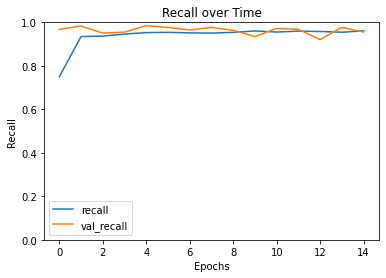

In [18]:
plt.plot(history['recalls'], label='recall')
plt.plot(history['val_recalls'], label = 'val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.title("Recall over Time")
plt.legend()
plt.show()

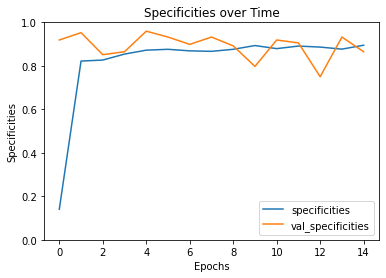

In [19]:
plt.plot(history['specificities'], label='specificities')
plt.plot(history['val_specificities'], label = 'val_specificities')
plt.xlabel('Epochs')
plt.ylabel('Specificities')
plt.ylim(0, 1)
plt.title("Specificities over Time")
plt.legend()
plt.show()

In [20]:
_ = save_model(model, './trained_models/model.pth', history)

# Train CNN using Class Weights

In [21]:
class_weights_model = CNN().to(DEVICE)

In [22]:
optimizer = torch.optim.Adam(class_weights_model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
class_weights_history = {
    'losses': [],
    'val_losses': [],
    'accuracies':[],
    'val_accuracies':[],
    'precisions': [],
    'val_precisions': [],
    'recalls': [],
    'val_recalls': [],
    'specificities': [],
    'val_specificities': [],
}
class_weights = compute_class_weight('balanced', classes=np.unique(train_split['class']), y=train_split['class'])

In [23]:
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(
        train_dataloader,
        class_weights_model,
        optimizer,
        DEVICE,
        class_weights_history,
        class_weights=class_weights
    )
    evaluate(
        val_dataloader,
        class_weights_model,
        DEVICE,
        class_weights_history,
        class_weights=class_weights
    )
print("Done!")

Epoch 1
-------------------------------
loss: 0.671633  [    0/ 4685]
loss: 0.785463  [  320/ 4685]
loss: 0.638810  [  640/ 4685]
loss: 0.690771  [  960/ 4685]
loss: 0.715624  [ 1280/ 4685]
loss: 0.576893  [ 1600/ 4685]
loss: 0.581760  [ 1920/ 4685]
loss: 0.600708  [ 2240/ 4685]
loss: 0.527843  [ 2560/ 4685]
loss: 0.321098  [ 2880/ 4685]
loss: 0.368657  [ 3200/ 4685]
loss: 0.358387  [ 3520/ 4685]
loss: 0.404724  [ 3840/ 4685]
loss: 0.330005  [ 4160/ 4685]
loss: 0.413096  [ 4480/ 4685]
Test Metrics:
Loss: 0.420264, Accuracy: 74.1%, Precision: 65.0%, Recall: 99.3%, Specificity: 98.6%

Epoch 2
-------------------------------
loss: 0.369278  [    0/ 4685]
loss: 0.392262  [  320/ 4685]
loss: 0.601047  [  640/ 4685]
loss: 0.309836  [  960/ 4685]
loss: 0.360958  [ 1280/ 4685]
loss: 0.507884  [ 1600/ 4685]
loss: 0.290706  [ 1920/ 4685]
loss: 0.280262  [ 2240/ 4685]
loss: 0.132346  [ 2560/ 4685]
loss: 0.298151  [ 2880/ 4685]
loss: 0.438172  [ 3200/ 4685]
loss: 0.182733  [ 3520/ 4685]
loss: 0.34

In [24]:
print('Evaluating on Test Data\n-----------------------------')
y_pred, y_true = evaluate(
    test_dataloader,
    class_weights_model,
    DEVICE,
    class_weights_history,
    mode='test',
    class_weights=class_weights
)

Evaluating on Test Data
-----------------------------
Test Metrics:
Loss: 0.167414, Accuracy: 90.7%, Precision: 92.0%, Recall: 99.2%, Specificity: 98.1%



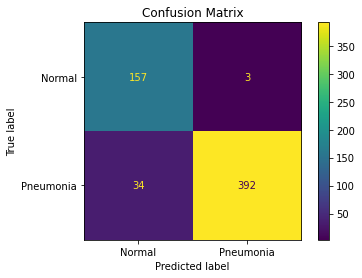

In [25]:
plot_confusion_matrix(y_pred, y_true)

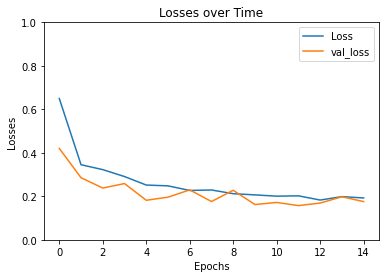

In [26]:
plt.plot(class_weights_history['losses'], label='Loss')
plt.plot(class_weights_history['val_losses'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.ylim(0, 1)
plt.title("Losses over Time")
plt.legend()
plt.show()

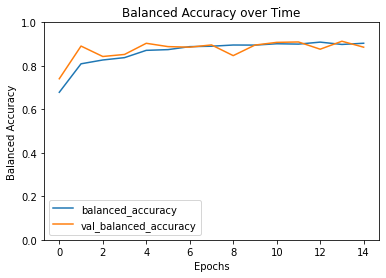

In [27]:
plt.plot(class_weights_history['accuracies'], label='balanced_accuracy')
plt.plot(class_weights_history['val_accuracies'], label = 'val_balanced_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.ylim(0, 1)
plt.title("Balanced Accuracy over Time")
plt.legend()
plt.show()

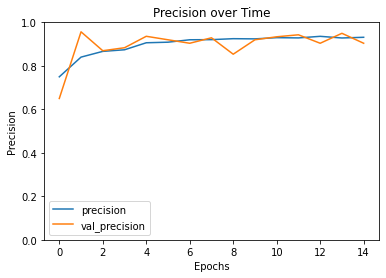

In [28]:
plt.plot(class_weights_history['precisions'], label='precision')
plt.plot(class_weights_history['val_precisions'], label = 'val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.title("Precision over Time")
plt.legend()
plt.show()

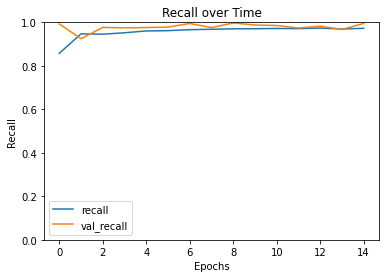

In [29]:
plt.plot(class_weights_history['recalls'], label='recall')
plt.plot(class_weights_history['val_recalls'], label = 'val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.title("Recall over Time")
plt.legend()
plt.show()

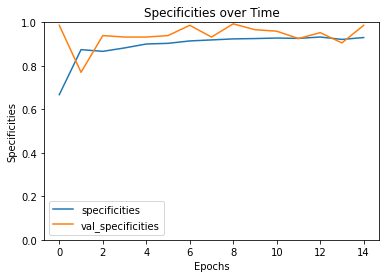

In [30]:
plt.plot(class_weights_history['specificities'], label='specificities')
plt.plot(class_weights_history['val_specificities'], label = 'val_specificities')
plt.xlabel('Epochs')
plt.ylabel('Specificities')
plt.ylim(0, 1)
plt.title("Specificities over Time")
plt.legend()
plt.show()

In [31]:
_ = save_model(class_weights_model, './trained_models/class_weights.pth', class_weights_history, used_weights=True)

# Model Analysis using Captum

#### Model Trained without Class Weights

In [34]:
l = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)]

In [35]:
size = (128, 128)

img_path, label = './data/chest_xray/test/PNEUMONIA/person135_bacteria_647.jpeg', 1
img_path2, label2 = './data/chest_xray/test/NORMAL/im-0001-0001.jpeg', 0
img = imread(img_path, IMREAD_GRAYSCALE)
img2 = imread(img_path2, IMREAD_GRAYSCALE)
img = resize(img, size)
img2 = resize(img2, size)

temp = ToTensor()
imgTens = temp(img)
imgTens = torch.unsqueeze(imgTens, 1)
img = np.reshape(img, (128, 128, 1))

imgTens2 = temp(img2)
imgTens2 = torch.unsqueeze(imgTens2, 1)
img2 = np.reshape(img2, (128, 128, 1))

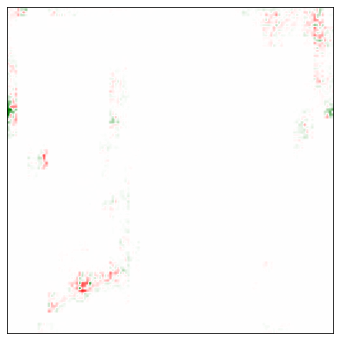

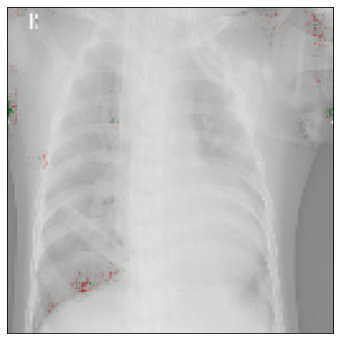

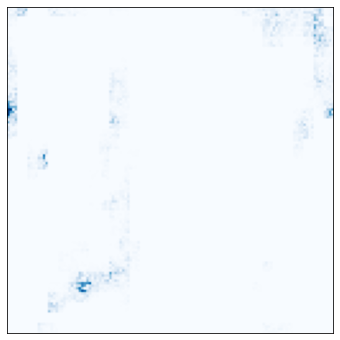

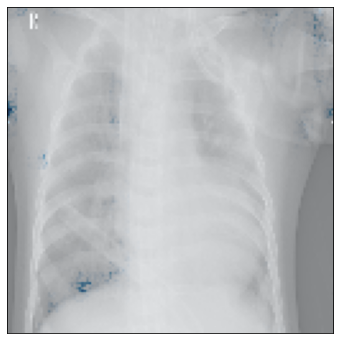

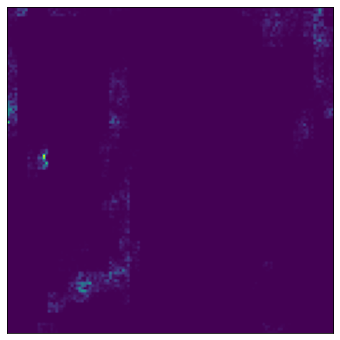

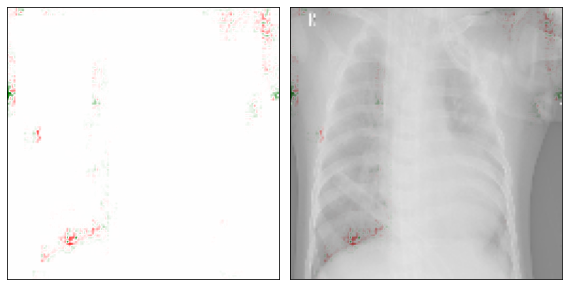

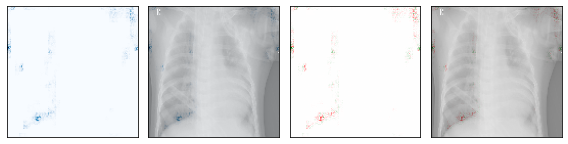

In [36]:
guided_gradcam = GuidedGradCam(model, l[9])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, sign='all', method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, sign='all', method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, sign='absolute_value', method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='masked_image')
captum.attr.visualization.visualize_image_attr_multiple(attribution, original_image=img, methods=['heat_map', 'blended_heat_map'], signs=['all', 'all'])
captum.attr.visualization.visualize_image_attr_multiple(attribution, original_image=img, methods=['heat_map', 'blended_heat_map', 'heat_map', 'blended_heat_map'], signs=['absolute_value', 'absolute_value', 'all', 'all'])
plt.show()

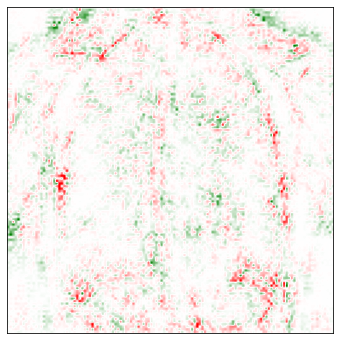

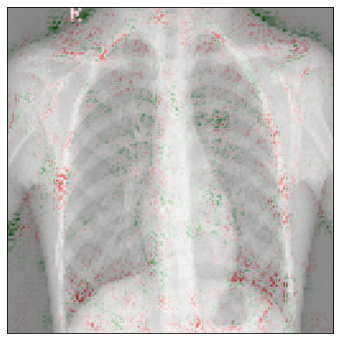

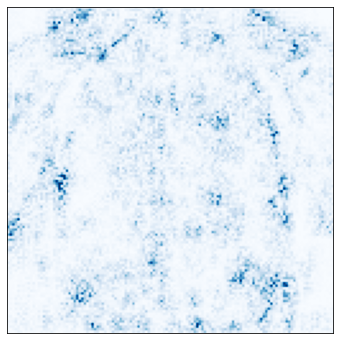

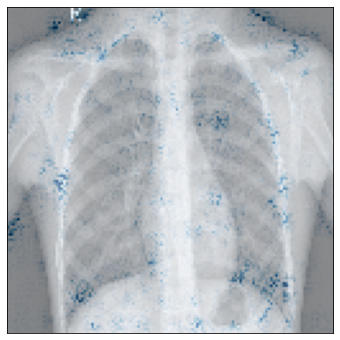

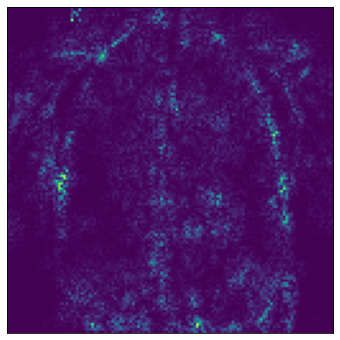

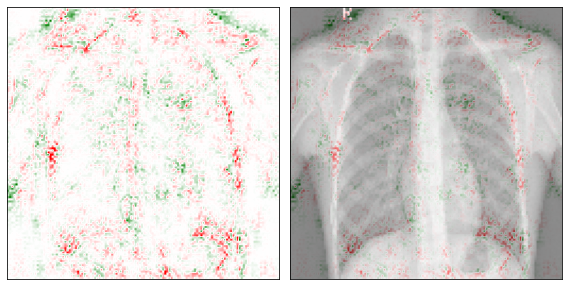

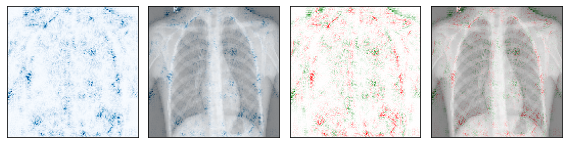

In [37]:
guided_gradcam = GuidedBackprop(model)
attribution = guided_gradcam.attribute(imgTens2)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, sign='all', method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, sign='all', method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, sign='absolute_value', method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='masked_image')
captum.attr.visualization.visualize_image_attr_multiple(attribution, original_image=img2, methods=['heat_map', 'blended_heat_map'], signs=['all', 'all'])
captum.attr.visualization.visualize_image_attr_multiple(attribution, original_image=img2, methods=['heat_map', 'blended_heat_map', 'heat_map', 'blended_heat_map'], signs=['absolute_value', 'absolute_value', 'all', 'all'])
plt.show()

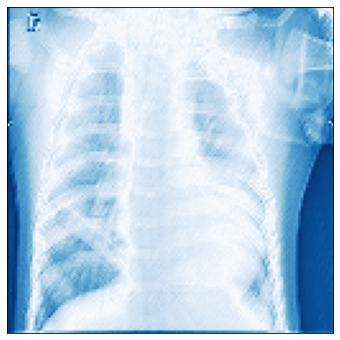

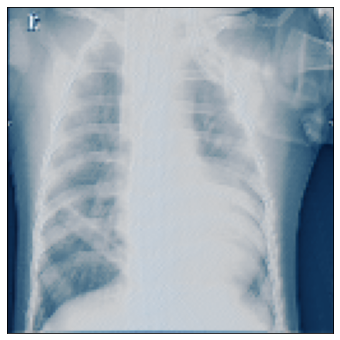

In [38]:
guided_gradcam = LayerGradCam(model, l[1])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')
plt.show()

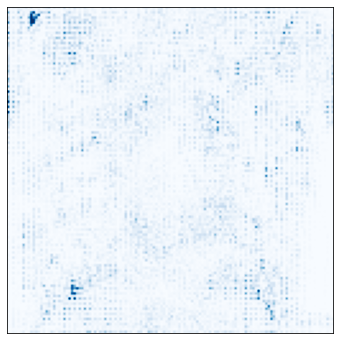

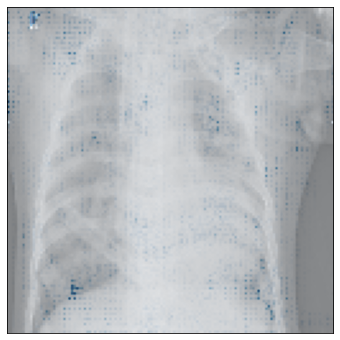

In [39]:
guided_gradcam = LayerConductance(model, l[1])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')
plt.show()

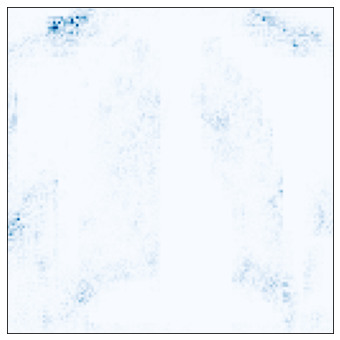

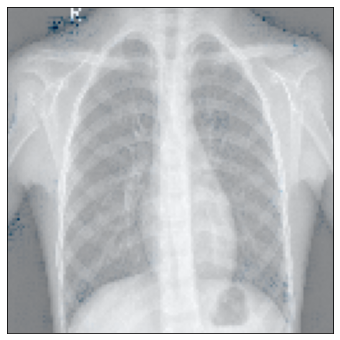

In [40]:
guided_gradcam = GuidedGradCam(model, l[9])
attribution = guided_gradcam.attribute(imgTens2)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='blended_heat_map')
plt.show()

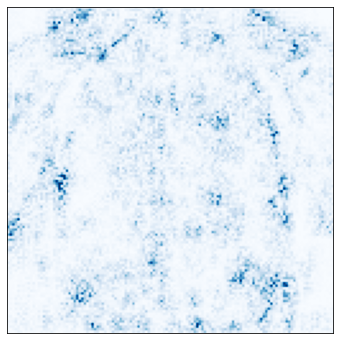

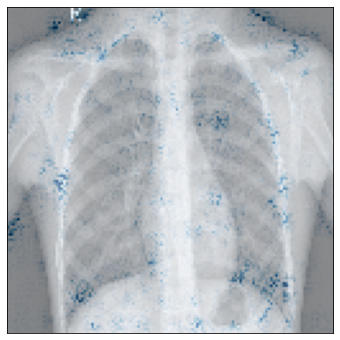

In [41]:
guided_gradcam = GuidedBackprop(model)
attribution = guided_gradcam.attribute(imgTens2)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='blended_heat_map')
plt.show()

#### Model Trained using Class Weights

In [42]:
l = [module for module in class_weights_model.modules() if not isinstance(module, torch.nn.Sequential)]

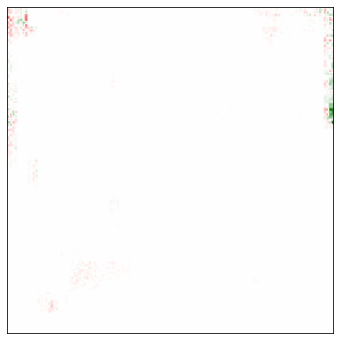

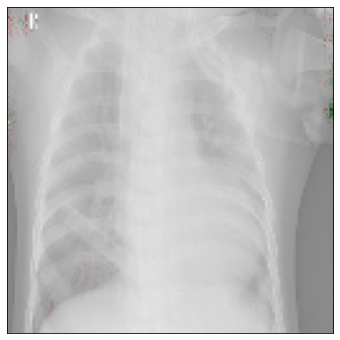

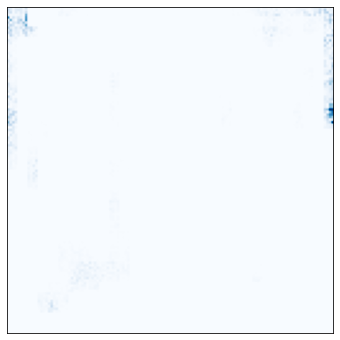

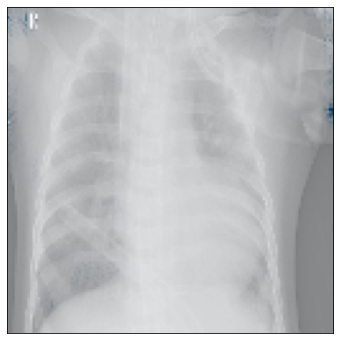

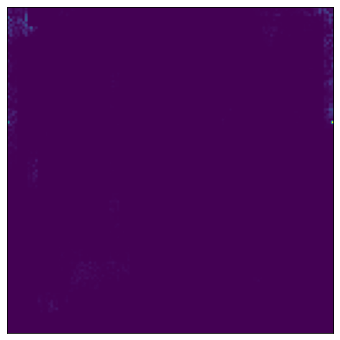

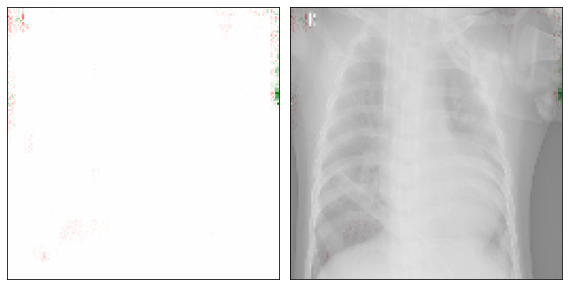

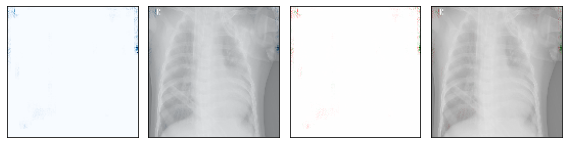

In [43]:
guided_gradcam = GuidedGradCam(class_weights_model, l[9])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, sign='all', method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, sign='all', method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, sign='absolute_value', method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='masked_image')
captum.attr.visualization.visualize_image_attr_multiple(attribution, original_image=img, methods=['heat_map', 'blended_heat_map'], signs=['all', 'all'])
captum.attr.visualization.visualize_image_attr_multiple(attribution, original_image=img, methods=['heat_map', 'blended_heat_map', 'heat_map', 'blended_heat_map'], signs=['absolute_value', 'absolute_value', 'all', 'all'])
plt.show()

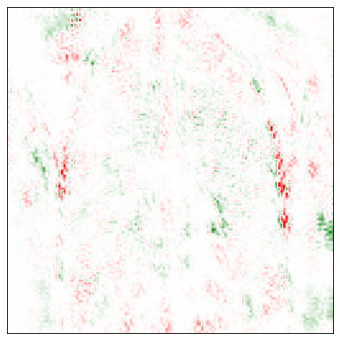

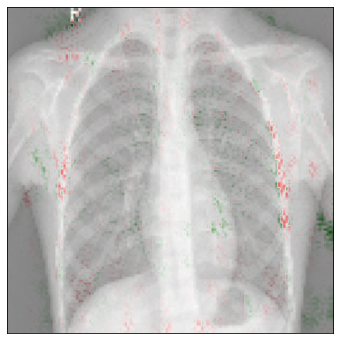

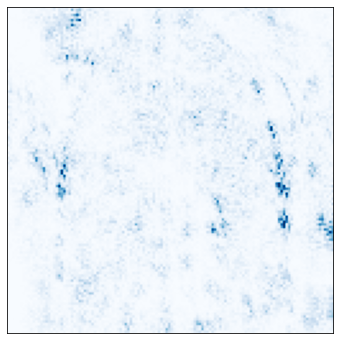

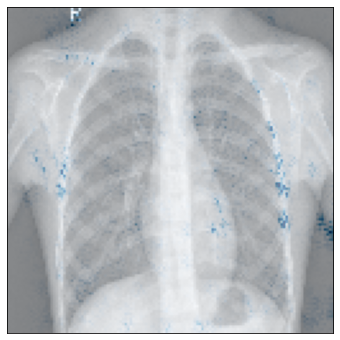

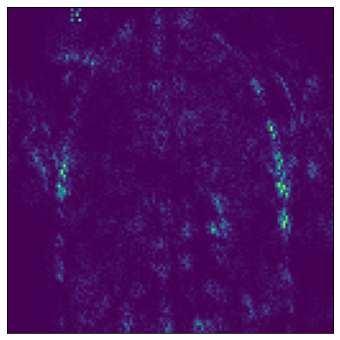

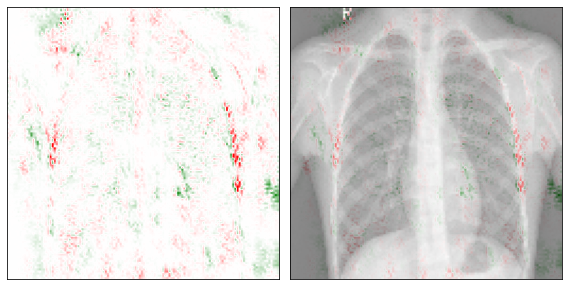

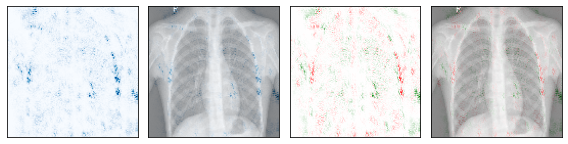

In [46]:
guided_gradcam = GuidedBackprop(class_weights_model)
attribution = guided_gradcam.attribute(imgTens2)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, sign='all', method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, sign='all', method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, sign='absolute_value', method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='masked_image')
captum.attr.visualization.visualize_image_attr_multiple(attribution, original_image=img2, methods=['heat_map', 'blended_heat_map'], signs=['all', 'all'])
captum.attr.visualization.visualize_image_attr_multiple(attribution, original_image=img2, methods=['heat_map', 'blended_heat_map', 'heat_map', 'blended_heat_map'], signs=['absolute_value', 'absolute_value', 'all', 'all'])
plt.show()

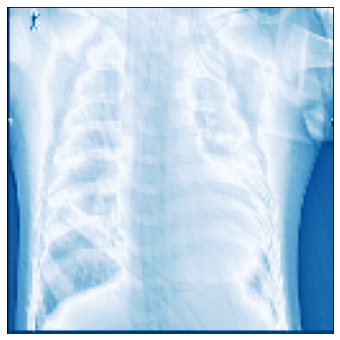

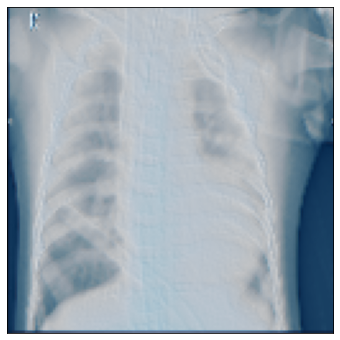

In [47]:
guided_gradcam = LayerGradCam(class_weights_model, l[1])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')
plt.show()

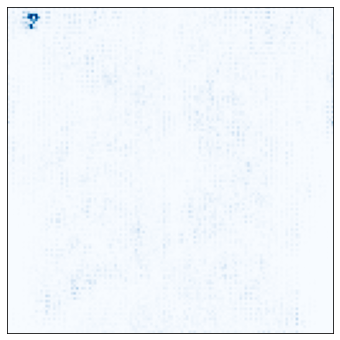

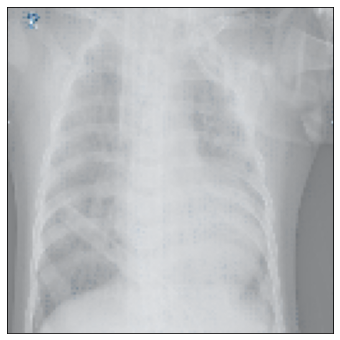

In [48]:
guided_gradcam = LayerConductance(class_weights_model, l[1])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')
plt.show()

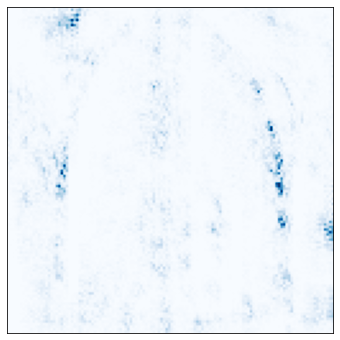

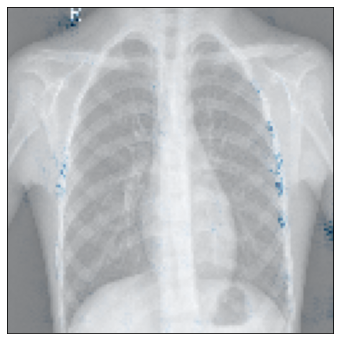

In [49]:
guided_gradcam = GuidedGradCam(class_weights_model, l[9])
attribution = guided_gradcam.attribute(imgTens2)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='blended_heat_map')
plt.show()

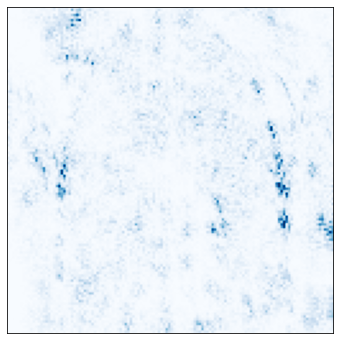

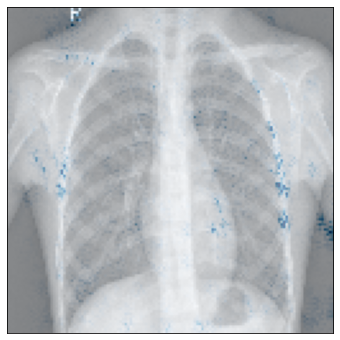

In [50]:
guided_gradcam = GuidedBackprop(class_weights_model)
attribution = guided_gradcam.attribute(imgTens2)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='blended_heat_map')
plt.show()